# Tuning

Попробуем улучшить метрики бейзлайна, уменьшить переобучение.

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

from sklearn.preprocessing import MinMaxScaler, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_score, recall_score, mean_absolute_error, accuracy_score, \
f1_score, log_loss, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from get_metrics import get_metrics_classification

import optuna
from optuna.integration import LightGBMPruningCallback

from tqdm import tqdm_notebook

In [2]:
def plot_confusion_matrix(y_true, X, ax, model=None, prediction=None):
    """Визуализация ConfusionMatrix"""
    if prediction is None:
        prediction = model.predict(X_test)
        
    labels = list(set(prediction))
    cm_ovr = confusion_matrix(y_test, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_ovr, display_labels=labels)
    
    if ax:
        disp.plot(ax=ax)

In [3]:
def check_overfitting(metric_fun,
                      y_train,
                      y_test,
                      X_train=None,
                      X_test=None,
                      model=None,
                      y_train_proba=None,
                      y_test_proba=None):
    """
    Проверка на overfitting
    """
    if model is None:
        value_train = metric_fun(y_train, y_train_proba)
        value_test = metric_fun(y_test, y_test_proba)
    else:
        if metric_fun.__name__ == 'roc_auc_score':
            y_pred_train = model.predict_proba(X_train)[:, 1]
            y_pred_test = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
        value_train = metric_fun(y_train, y_pred_train)
        value_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % value_train)
    print(f'{metric_fun.__name__} test: %.3f' % value_test)
    print(f'delta = {(abs(value_train - value_test)/value_test*100):.1f} %')

In [4]:
# Установим в самом начале глобальные переменные (параметры)
RAND = 10
N_FOLDS = 5

In [5]:
# Целевая функция для оптимизации параметров классификатора (оптюны)
def objective_lgb(trial, X, y, random_state=10):
    
    lgb_params = {
        
        """Признаки для бинарной классификации с помощью алгоритма LGBM"""
        
        "n_estimators":
        trial.suggest_categorical("n_estimators", [700]),
        "verbosity": -1,
        # Добавлены новые признаки к тем, что в лекции для улучшения парметров
        "learning_rate":
        trial.suggest_categorical("learning_rate", [0.1]),
        "num_class": 1,
        "num_leaves":
        trial.suggest_int("num_leaves", 66, 66),
        "max_depth":
        trial.suggest_int("max_depth", 9, 9),
        "min_child_samples":
        trial.suggest_int("min_child_samples", 7, 7),
        "reg_alpha":
        trial.suggest_float("reg_alpha", 0.0038, 0.004, log=True),
        "gamma":
        trial.suggest_int("gamma", 2, 2),
        "reg_lambda":
        trial.suggest_float("reg_lambda", 4.8, 5.06, log=True),
        "min_split_gain":
        trial.suggest_int("min_split_gain", 1, 1),
        "subsample":
        trial.suggest_float("subsample", 0.8, 0.9),
        "subsample_freq":
        trial.suggest_categorical("subsample_freq", [1]),
        "colsample_bytree":
        trial.suggest_float("colsample_bytree", 0.98, 1.0),
        "objective":
        trial.suggest_categorical("objective", ["binary"]),
        "random_state":
        trial.suggest_categorical("random_state", [random_state]),
        "boosting_type":
        "gbdt",
        "lambda_l1":
        trial.suggest_float("lambda_l1", 0.13, 0.18, log=True),
        "lambda_l2":
        trial.suggest_float("lambda_l2", 0.0095, 0.014, log=True),
        "feature_fraction":
        trial.suggest_float("feature_fraction", 0.78, 0.8),
    }
    
    
    N_FOLDS = 3
    cv = KFold(n_splits=N_FOLDS, shuffle=True)
    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # параметр для стрижки деревьев алгоритма LGBMClassificier
    pruning_callback = LightGBMPruningCallback(trial, "binary_logloss")
    model = LGBMClassifier(**lgb_params,
                           early_stopping_rounds=100,
                           scale_pos_weight=ratio)
    
    # обучаем модель                       
    model.fit(X_train,
              y_train,
              eval_metric="auc",
              eval_set=[(X_test, y_test)],
              callbacks=[pruning_callback,
                         lgb.early_stopping(100)])

    preds = model.predict(X_test)
    cv_predicts[idx] =  roc_auc_score(y_test, preds)
    return np.mean(cv_predicts)

In [6]:
# Импорт данных (таблицы из файла)
df = pd.read_csv('Train.csv')

In [7]:
# Общая информаця о признаках
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4020 entries, 0 to 4019
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Person_id        4020 non-null   object 
 1   Survey_date      4020 non-null   object 
 2   Round            4020 non-null   int64  
 3   Status           4020 non-null   object 
 4   Tenure           2626 non-null   float64
 5   Geography        4020 non-null   object 
 6   Province         4020 non-null   object 
 7   Matric           3012 non-null   float64
 8   Degree           2189 non-null   float64
 9   Diploma          2211 non-null   float64
 10  Schoolquintile   2359 non-null   float64
 11  Math             997 non-null    object 
 12  Mathlit          1353 non-null   object 
 13  Additional_lang  2018 non-null   object 
 14  Home_lang        381 non-null    object 
 15  Science          732 non-null    object 
 16  Female           4020 non-null   int64  
 17  Sa_citizen    

In [8]:
# Удаляем неинформативные признаки: ID, Дату опроса и столбец, в котором практически все значения одинаковые.
df = df.drop(["Person_id", "Survey_date", "Sa_citizen", "Round"], axis = 1)

In [9]:
# Часть пропусков можно заполнить нулями
df['Tenure'] = np.where(df.Status == 'studying', 0, df.Tenure)
df['Tenure'] = np.where(df.Status == 'other', 0, df.Tenure)

# Остальные в признаке заполняем модой
df['Tenure'] = df.Tenure.fillna(df.Tenure.mode()[0])

In [10]:
# Создадим копию датасета для обучения на логарифмированных признаках
dfl = df.copy()

dfl['Birthyear'] = np.log(df['Birthyear'] + 1)
dfl['Tenure'] = np.log(df['Tenure'])
dfl.loc[dfl['Tenure'] < 0, 'Tenure'] = 0

In [11]:
# Заполним пропуски в остальных признаках значением 'None', т.к. они либо категориальные, либо бинарные.
dfl = dfl.fillna('None')

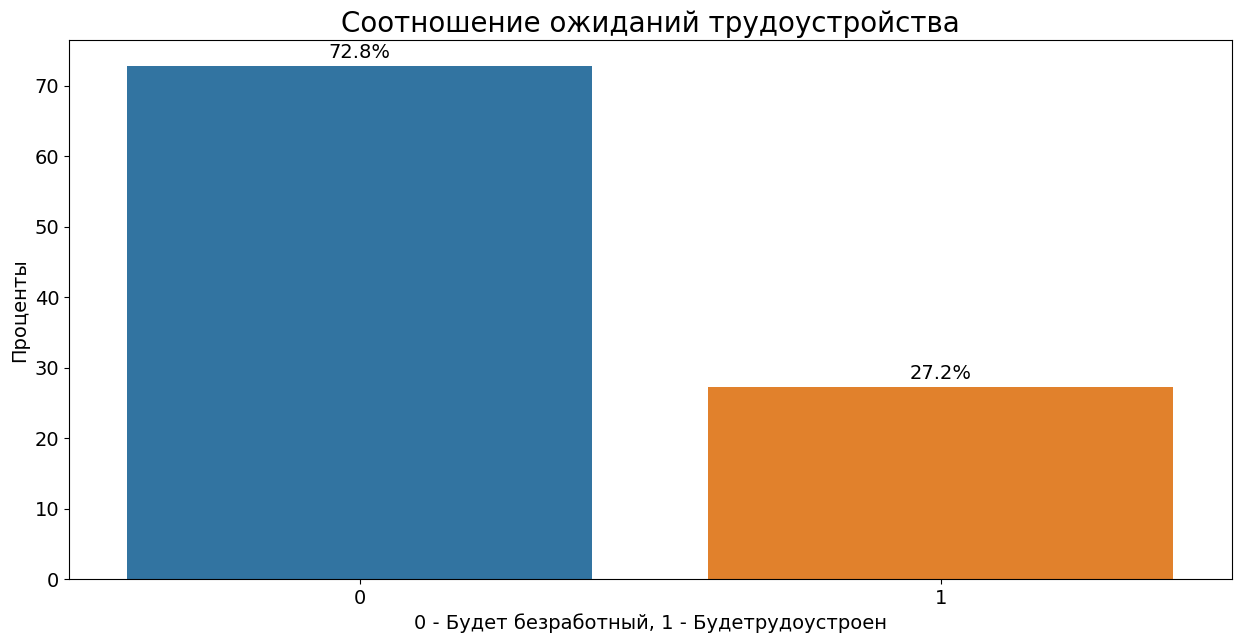

In [12]:
# Из исследовательской части выявлен дизбаланс классов целевой переменной.
# Снова нормируем на размер датасета
norm_target = (dfl.Target.value_counts(
    normalize=True).mul(100).rename('percent').reset_index())

# Вывод фигуры графика
plt.figure(figsize=(15, 7))
ax = sns.barplot(x=dfl.Target, y='percent', data=norm_target)

# Вывод надписей
for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)

plt.title('Соотношение ожиданий трудоустройства', fontsize=20)
plt.xlabel('0 - Будет безработный, 1 - Будетрудоустроен', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [13]:
X = pd.get_dummies(dfl.drop(['Target'], axis=1))
y = dfl['Target']

# Разобъем датасет на тренировочные и тестовые данные и так как имеет место дизбаланс классов, 
#так же передаем параметр stratify = y, чтобы сохранить исходное соотношение классов в train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y_train,
                                                    random_state=RAND)

dtrain = lgb.Dataset(X_train, label=y_train)
train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)

# Создаем эксземпляр класса бейзлайна
lgbm_ = LGBMClassifier(random_state=RAND, scale_pos_weight=ratio, early_stopping_rounds=100)
eval_set = [(X_val, y_val)]

# Обучаем алгоритм на бинаризованных данных
lgbm_.fit(X_train,
        y_train,
        eval_metric="auc",
        eval_set=eval_set)

# Потенцируем признаки
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

y_pred = lgbm_.predict(X_test)
y_score = lgbm_.predict_proba(X_test)

metrics = get_metrics_classification(y_test,
                               y_pred,
                               y_score,
                           name='LGBM_baseline_BIN')

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 874, number of negative: 2342
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 3216, number of used features: 67
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271766 -> initscore=-0.985680
[LightGBM] [Info] Start training from score -0.985680
Training u

,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
model,,,,,,
LGBM_baseline_BIN,0.756,0.794,0.552,0.562,0.557,0.499


In [14]:
X['Birthyear'] = np.log(X['Birthyear'] + 1)
X['Tenure'] = np.log(X['Tenure'])

# Улучшаем параметры с помощью optuna
study = optuna.create_study(direction="minimize", study_name="LGB_21")
optuna.logging.set_verbosity(optuna.logging.WARNING)
func = lambda trial: objective_lgb(trial, X_train, y_train, random_state=RAND)

# Передаем функцию с обучением в optuna
study.optimize(func, n_trials=5, show_progress_bar=True)

[I 2023-10-29 12:36:49,246] A new study created in memory with name: LGB_21


  0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[63]	valid_0's auc: 0.812041	valid_0's binary_logloss: 0.480833
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's auc: 0.781822	valid_0's binary_logloss: 0.511676
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds


In [15]:
# Создаем экземпляр класса для обучения на лучших параметрах
lgbm_b = LGBMClassifier(**study.best_params, early_stopping_rounds=100, scale_pos_weight=ratio, verbosity=-1)
lgbm_b.fit(X_train,
             y_train,
             eval_set=eval_set,
             eval_metric='auc',
             )

# Потенцируем признаки для сравнения результатов обучения
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

y_pred = lgbm_b.predict(X_test)
y_score = lgbm_b.predict_proba(X_test)


# Добавим метрики результатов обучения на луших параметрах
metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test=y_test,
                               y_pred=y_pred,
                               y_score=y_score,
                               name='LGBM_Optuna_bestparams')])

round(metrics.set_index('model'), 3)

metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_baseline_BIN,0.756219,0.794364,0.551570,0.561644,0.556561,0.498931
0,LGBM_Optuna_bestparams,0.763682,0.808196,0.559184,0.625571,0.590517,0.490690


In [16]:
# Переобучение после оптюны
check_overfitting(model=lgbm_b,
                  X_train=X_train,
                  y_train=y_train,
                  X_test=X_test,
                  y_test=y_test,
                  metric_fun=roc_auc_score)

roc_auc_score train: 0.953
roc_auc_score test: 0.808
delta = 17.9 %


С помощью оптюны удалось не только подобрать лучшие параметры, но и уменьшить переобучение c 23.4% до 18,9%.
Далее рассмотрим стекинг для уменьшения переобучения.

In [17]:
# Выведем параметры, при которых наилучшие значения метрик
study.best_params

{'n_estimators': 700,
 'learning_rate': 0.1,
 'num_leaves': 66,
 'max_depth': 9,
 'min_child_samples': 7,
 'reg_alpha': 0.003909340940449294,
 'gamma': 2,
 'reg_lambda': 4.924630627904611,
 'min_split_gain': 1,
 'subsample': 0.8971672623171643,
 'subsample_freq': 1,
 'colsample_bytree': 0.9900602557650716,
 'objective': 'binary',
 'random_state': 10,
 'lambda_l1': 0.16516891601276332,
 'lambda_l2': 0.009631444915531612,
 'feature_fraction': 0.7913048349119874}

В результате ряда итераций удалось зафиксировать некоторые парметры, при которых значения auc получались не ниже бейзлайна, достигали 0,795-0,806. Accuracy и recall стали намного выше, а значения ошибки logloss меньше. Единственная метрика, которая пострадала - это recall, но она не является ключевой. При помощи оптюны ключевые метрики улучишились, ошибка logloss стала меньше.
Параметры, которые улучшили модель - число листьев, глубина дерева, минимальный наследственный. У итераций с лучшими метриками данные параметры не очень отличались друг от друга, но разброс значений штрафовальщиков был большой. При фиксации оптимальных парметров дерева - глубины, количества листев, и пр. и одновременном  уменьшении предельных значений регуляризаторов дали в совокупнности лучший результат.

In [18]:
# Запишем лучшие параметры по результам нескольких экспериментов, при котором рок аук 0,81
thebest = {'n_estimators': 700,
 'learning_rate': 0.1,
 'num_leaves': 66,
 'max_depth': 9,
 'min_child_samples': 7,
 'reg_alpha': 0.003947220274835413,
 'gamma': 2,
 'reg_lambda': 4.871277690668917,
 'min_split_gain': 1,
 'subsample': 0.8758410898086639,
 'subsample_freq': 1,
 'colsample_bytree': 0.9995288858747634,
 'objective': 'binary',
 'random_state': 10,
 'lambda_l1': 0.15598488658869133,
 'lambda_l2': 0.012865686652754702,
 'feature_fraction': 0.793357918073851}

In [19]:
# Создаем экземпляр класса для обучения на лучших параметрах, при которых наилучшие показатели.
X['Birthyear'] = np.log(X['Birthyear'] + 1)
X['Tenure'] = np.log(X['Tenure'])

lgbm_best = LGBMClassifier(**thebest, early_stopping_rounds=100, scale_pos_weight=ratio, verbosity=-1)
lgbm_best.fit(X_train,
             y_train,
             eval_set=eval_set,
             eval_metric='auc',
             )

# Потенцируем признаки для сравнения результатов обучения
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

y_pred = lgbm_best.predict(X_test)
y_score = lgbm_best.predict_proba(X_test)


# Добавим метрики результатов обучения на луших параметрах
metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test=y_test,
                               y_pred=y_pred,
                               y_score=y_score,
                               name='LGBM_Optuna_best')])

round(metrics.set_index('model'), 3)

metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_baseline_BIN,0.756219,0.794364,0.551570,0.561644,0.556561,0.498931
0,LGBM_Optuna_bestparams,0.763682,0.808196,0.559184,0.625571,0.590517,0.490690
0,LGBM_Optuna_best,0.754975,0.810444,0.547414,0.579909,0.563193,0.482441


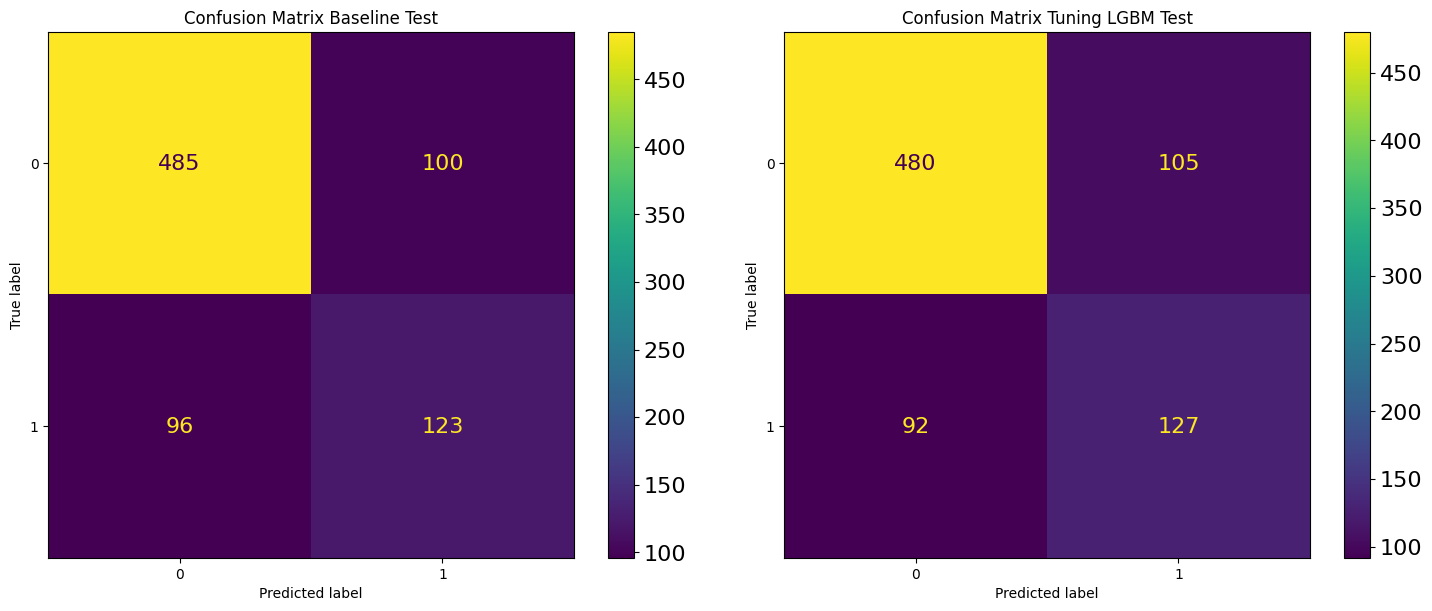

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(y_true=y_test, X=X_test, model=lgbm_, ax=ax[0])
plt.rcParams.update({'font.size': 16})
plot_confusion_matrix(y_true=y_test, X=X_test, model=lgbm_best, ax=ax[1])

ax[0].title.set_text('Confusion Matrix Baseline Test')
ax[1].title.set_text('Confusion Matrix Tuning LGBM Test')
plt.tight_layout()  
plt.show()

Задача в данном исследовании - точнее угадать класс 0 - кто будет безработный. Несмотря на лучшие метрики, бейзлайн на тестовых данных, лучше справился с данной задачей.
Рассморим стекинг для борьбы с переобучением, его метрики и точность предсказаний классов.

# Стекинг

In [21]:
# Пусть первая модель будет после оптюны на лучших паарметрах
clf1 = LGBMClassifier(**study.best_params, early_stopping_rounds=100, verbosity=-1, scale_pos_weight=ratio)
# Вторая на лучших результатах ряда экспериментов
clf2 = LGBMClassifier(**thebest, early_stopping_rounds=100, verbosity=-1, scale_pos_weight=ratio)

In [22]:
# Третья - оптимизируем baseline Catboost
X['Birthyear'] = np.log(X['Birthyear'] + 1)
X['Tenure'] = np.log(X['Tenure'])
def objective_catb(trial, X, y, random_state=10):
        
    catb_params = {
    #Признаки для бинарной классификаци с помощью алгоритма CatBoost
    "iterations":trial.suggest_int("iterations", 526, 526),
    "learning_rate":trial.suggest_float("learning_rate", 0.04, 0.055, log=True),
    "depth":trial.suggest_int("depth", 4, 4),
    #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 0.1),
    "l2_leaf_reg":trial.suggest_float("l2_leaf_reg", 6.7, 7.5, log=True),
    "bootstrap_type":trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
  #  "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
    "random_strength":trial.suggest_float("random_strength", 0.2, 2.0, log=True),
  #  "bagging_temperature":trial.suggest_float("bagging_temperature", 5.0, 10.0),
    "od_type":trial.suggest_categorical("od_type", ["Iter"]),
    "verbose":False,
    }
    
    
    cv = KFold(n_splits=N_FOLDS, shuffle=True)
    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = CatBoostClassifier(**catb_params,
                           early_stopping_rounds=100,
                           scale_pos_weight=ratio,
                           eval_metric='AUC')
    
    # обучаем модель                       
    model.fit(X_train,
              y_train,
              eval_set=[(X_test, y_test)]),
              
    preds = model.predict(X_test)
    cv_predicts[idx] =  roc_auc_score(y_test, preds)
    return np.mean(cv_predicts)

# Улучшаем параметры с помощью optuna
study_cat = optuna.create_study(direction="maximize", study_name="Catb_opt")
optuna.logging.set_verbosity(optuna.logging.WARNING)
func = lambda trial: objective_catb(trial, X_train, y_train, random_state=RAND)

# Передаем функцию с обучением в optuna
study_cat.optimize(func, n_trials=10, show_progress_bar=True)

#Создаем эксземпляр класса
clf_catb = CatBoostClassifier(**study_cat.best_params,
                           early_stopping_rounds=100,
                           scale_pos_weight=ratio
                             )
# Обучаем алгоритм
clf_catb.fit(X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
# Потенцируем данные обратно
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])
y_predc = clf_catb.predict(X_test)
y_scorec = clf_catb.predict_proba(X_test)
metrics = pd.concat([
    metrics,
    get_metrics_classification(y_test=y_test,
                               y_pred=y_predc,
                               y_score=y_scorec,
                               name='catt_Optuna_bestparams')])
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_baseline_BIN,0.756219,0.794364,0.551570,0.561644,0.556561,0.498931
0,LGBM_Optuna_bestparams,0.763682,0.808196,0.559184,0.625571,0.590517,0.490690
0,LGBM_Optuna_best,0.754975,0.810444,0.547414,0.579909,0.563193,0.482441
0,catt_Optuna_bestparams,0.733831,0.780354,0.510288,0.566210,0.536797,0.522352


Catboost не удалось оптимизировать, метрики остались на уровне бейзлайна (ноутбук Employment Research). Возможно, необходимо было дольше подбирать параметры, но ограничение по времени так же имеет место. Возьмем для стекинга получившийся алгоритм.

In [24]:
# Третья модель на результатах оптюны. Чтобы не нагружать исследование бейзлайном, оставим как есть
clf3 = CatBoostClassifier(**study_cat.best_params, early_stopping_rounds=100, scale_pos_weight=ratio)

In [25]:
models_check = [clf1, clf2, clf3]
clf1.fit(X_train,
             y_train,
             eval_set=eval_set,
             eval_metric='auc',
             )
clf2.fit(X_train,
             y_train,
             eval_set=eval_set,
             eval_metric='auc',
             )
clf3.fit(X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

# Потенцируем данные обратно
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

for model in models_check:
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)

    metrics = metrics.append(
        get_metrics_classification(y_test,
                                   y_pred,
                                   y_score,
                                   name=f'{model.__class__.__name__}'))

In [26]:
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_baseline_BIN,0.756219,0.794364,0.551570,0.561644,0.556561,0.498931
0,LGBM_Optuna_bestparams,0.763682,0.808196,0.559184,0.625571,0.590517,0.490690
0,LGBM_Optuna_best,0.754975,0.810444,0.547414,0.579909,0.563193,0.482441
0,catt_Optuna_bestparams,0.733831,0.780354,0.510288,0.566210,0.536797,0.522352
0,LGBMClassifier,0.763682,0.808196,0.559184,0.625571,0.590517,0.490690
0,LGBMClassifier,0.754975,0.810444,0.547414,0.579909,0.563193,0.482441
0,CatBoostClassifier,0.733831,0.780354,0.510288,0.566210,0.536797,0.522352


In [27]:
# Добавляем модели по очереди для стекинга

meta_X = pd.DataFrame()
meta_X_test = pd.DataFrame()


pred_val = []
pred_score_val = []
X['Birthyear'] = np.log(X['Birthyear'] + 1)
X['Tenure'] = np.log(X['Tenure'])

cv = StratifiedKFold(n_splits=3)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    clf1.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="auc",
              )

    y_pred_val = clf1.predict(X_val)
    y_score_val = clf1.predict_proba(X_val)

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

# обучаем модель для предсказания на test
model.fit(X_train, y_train)

meta_X['lgb_bestparams'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['lgb_bestparams'] = clf1.predict_proba(X_test)[:,1]

0:	learn: 0.6783975	total: 1.91ms	remaining: 1s
1:	learn: 0.6655677	total: 3.99ms	remaining: 1.04s
2:	learn: 0.6527713	total: 5.7ms	remaining: 994ms
3:	learn: 0.6415608	total: 7.38ms	remaining: 963ms
4:	learn: 0.6339571	total: 9.02ms	remaining: 940ms
5:	learn: 0.6256877	total: 10.7ms	remaining: 924ms
6:	learn: 0.6191048	total: 12.4ms	remaining: 918ms
7:	learn: 0.6115750	total: 14.3ms	remaining: 925ms
8:	learn: 0.6049333	total: 16ms	remaining: 917ms
9:	learn: 0.6011783	total: 17.6ms	remaining: 909ms
10:	learn: 0.5971255	total: 19.4ms	remaining: 906ms
11:	learn: 0.5948754	total: 21ms	remaining: 898ms
12:	learn: 0.5909931	total: 22.7ms	remaining: 896ms
13:	learn: 0.5879060	total: 24.4ms	remaining: 893ms
14:	learn: 0.5844589	total: 26.1ms	remaining: 889ms
15:	learn: 0.5826666	total: 27.8ms	remaining: 885ms
16:	learn: 0.5795964	total: 29.4ms	remaining: 880ms
17:	learn: 0.5773204	total: 31ms	remaining: 875ms
18:	learn: 0.5753160	total: 32.8ms	remaining: 875ms
19:	learn: 0.5732554	total: 34.5

239:	learn: 0.4721691	total: 394ms	remaining: 469ms
240:	learn: 0.4718218	total: 396ms	remaining: 468ms
241:	learn: 0.4716080	total: 398ms	remaining: 467ms
242:	learn: 0.4713863	total: 399ms	remaining: 465ms
243:	learn: 0.4711443	total: 401ms	remaining: 464ms
244:	learn: 0.4708327	total: 403ms	remaining: 462ms
245:	learn: 0.4705986	total: 405ms	remaining: 460ms
246:	learn: 0.4702991	total: 406ms	remaining: 459ms
247:	learn: 0.4701074	total: 408ms	remaining: 457ms
248:	learn: 0.4697892	total: 409ms	remaining: 456ms
249:	learn: 0.4696157	total: 411ms	remaining: 454ms
250:	learn: 0.4693621	total: 413ms	remaining: 452ms
251:	learn: 0.4689640	total: 414ms	remaining: 451ms
252:	learn: 0.4682393	total: 416ms	remaining: 449ms
253:	learn: 0.4680902	total: 418ms	remaining: 447ms
254:	learn: 0.4675885	total: 419ms	remaining: 446ms
255:	learn: 0.4674132	total: 421ms	remaining: 444ms
256:	learn: 0.4672380	total: 423ms	remaining: 442ms
257:	learn: 0.4668678	total: 424ms	remaining: 441ms
258:	learn: 

475:	learn: 0.4199902	total: 783ms	remaining: 82.3ms
476:	learn: 0.4198854	total: 785ms	remaining: 80.7ms
477:	learn: 0.4196772	total: 788ms	remaining: 79.1ms
478:	learn: 0.4195789	total: 789ms	remaining: 77.4ms
479:	learn: 0.4193616	total: 791ms	remaining: 75.8ms
480:	learn: 0.4192069	total: 793ms	remaining: 74.1ms
481:	learn: 0.4189385	total: 794ms	remaining: 72.5ms
482:	learn: 0.4187505	total: 796ms	remaining: 70.8ms
483:	learn: 0.4185010	total: 797ms	remaining: 69.2ms
484:	learn: 0.4183191	total: 799ms	remaining: 67.5ms
485:	learn: 0.4181247	total: 801ms	remaining: 65.9ms
486:	learn: 0.4179459	total: 802ms	remaining: 64.3ms
487:	learn: 0.4177510	total: 804ms	remaining: 62.6ms
488:	learn: 0.4176091	total: 806ms	remaining: 61ms
489:	learn: 0.4174631	total: 807ms	remaining: 59.3ms
490:	learn: 0.4173613	total: 809ms	remaining: 57.7ms
491:	learn: 0.4171045	total: 810ms	remaining: 56ms
492:	learn: 0.4170368	total: 812ms	remaining: 54.4ms
493:	learn: 0.4168221	total: 814ms	remaining: 52.7

In [28]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=3)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    clf2.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              eval_metric="auc",
              )

    y_pred_val = clf2.predict(X_val)
    y_score_val = clf2.predict_proba(X_val)

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

model.fit(X_train, y_train)

meta_X['lgb_best'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['lgb_best'] = clf2.predict_proba(X_test)[:,1]

0:	learn: 0.6783975	total: 1.99ms	remaining: 1.04s
1:	learn: 0.6655677	total: 4.18ms	remaining: 1.1s
2:	learn: 0.6527713	total: 6.26ms	remaining: 1.09s
3:	learn: 0.6415608	total: 7.94ms	remaining: 1.04s
4:	learn: 0.6339571	total: 9.59ms	remaining: 1000ms
5:	learn: 0.6256877	total: 11.2ms	remaining: 974ms
6:	learn: 0.6191048	total: 12.9ms	remaining: 954ms
7:	learn: 0.6115750	total: 14.5ms	remaining: 939ms
8:	learn: 0.6049333	total: 16.2ms	remaining: 929ms
9:	learn: 0.6011783	total: 17.8ms	remaining: 918ms
10:	learn: 0.5971255	total: 19.4ms	remaining: 910ms
11:	learn: 0.5948754	total: 21.1ms	remaining: 902ms
12:	learn: 0.5909931	total: 22.7ms	remaining: 895ms
13:	learn: 0.5879060	total: 24.3ms	remaining: 889ms
14:	learn: 0.5844589	total: 25.9ms	remaining: 883ms
15:	learn: 0.5826666	total: 27.9ms	remaining: 890ms
16:	learn: 0.5795964	total: 29.9ms	remaining: 896ms
17:	learn: 0.5773204	total: 31.6ms	remaining: 891ms
18:	learn: 0.5753160	total: 33.3ms	remaining: 887ms
19:	learn: 0.5732554	t

175:	learn: 0.4910547	total: 397ms	remaining: 790ms
176:	learn: 0.4907455	total: 399ms	remaining: 788ms
177:	learn: 0.4902286	total: 402ms	remaining: 785ms
178:	learn: 0.4899506	total: 404ms	remaining: 784ms
179:	learn: 0.4894009	total: 407ms	remaining: 781ms
180:	learn: 0.4890310	total: 409ms	remaining: 779ms
181:	learn: 0.4888390	total: 411ms	remaining: 777ms
182:	learn: 0.4885464	total: 413ms	remaining: 775ms
183:	learn: 0.4881818	total: 415ms	remaining: 772ms
184:	learn: 0.4879385	total: 418ms	remaining: 770ms
185:	learn: 0.4876755	total: 420ms	remaining: 768ms
186:	learn: 0.4875286	total: 422ms	remaining: 765ms
187:	learn: 0.4872920	total: 424ms	remaining: 762ms
188:	learn: 0.4869812	total: 426ms	remaining: 760ms
189:	learn: 0.4867697	total: 428ms	remaining: 757ms
190:	learn: 0.4865051	total: 430ms	remaining: 754ms
191:	learn: 0.4863151	total: 432ms	remaining: 752ms
192:	learn: 0.4860284	total: 435ms	remaining: 750ms
193:	learn: 0.4858051	total: 437ms	remaining: 748ms
194:	learn: 

361:	learn: 0.4413317	total: 786ms	remaining: 356ms
362:	learn: 0.4412033	total: 788ms	remaining: 354ms
363:	learn: 0.4410709	total: 790ms	remaining: 351ms
364:	learn: 0.4408363	total: 793ms	remaining: 350ms
365:	learn: 0.4407214	total: 795ms	remaining: 347ms
366:	learn: 0.4405294	total: 797ms	remaining: 345ms
367:	learn: 0.4403293	total: 799ms	remaining: 343ms
368:	learn: 0.4400760	total: 801ms	remaining: 341ms
369:	learn: 0.4399668	total: 803ms	remaining: 339ms
370:	learn: 0.4397616	total: 805ms	remaining: 336ms
371:	learn: 0.4395457	total: 807ms	remaining: 334ms
372:	learn: 0.4393279	total: 809ms	remaining: 332ms
373:	learn: 0.4392110	total: 811ms	remaining: 330ms
374:	learn: 0.4390639	total: 813ms	remaining: 328ms
375:	learn: 0.4389514	total: 815ms	remaining: 325ms
376:	learn: 0.4388566	total: 817ms	remaining: 323ms
377:	learn: 0.4383940	total: 819ms	remaining: 321ms
378:	learn: 0.4381844	total: 821ms	remaining: 318ms
379:	learn: 0.4379250	total: 823ms	remaining: 316ms
380:	learn: 

In [29]:
pred_val = []
pred_score_val = []

cv = StratifiedKFold(n_splits=3)
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    clf3.fit(X_train_,
              y_train_,
              eval_set=[(X_val, y_val)],
              early_stopping_rounds=100,
              verbose=False)

    y_pred_val = clf3.predict(X_val)
    y_score_val = clf3.predict_proba(X_val)

    # holdout list
    pred_val.append(y_pred_val)
    pred_score_val.append(y_score_val)

model.fit(X_train, y_train)

meta_X['lgb_best'] = np.concatenate(pred_score_val)[:,1]
meta_X_test['lgb_best'] = clf3.predict_proba(X_test)[:,1]

0:	learn: 0.6783975	total: 1.89ms	remaining: 992ms
1:	learn: 0.6655677	total: 3.98ms	remaining: 1.04s
2:	learn: 0.6527713	total: 5.86ms	remaining: 1.02s
3:	learn: 0.6415608	total: 9.23ms	remaining: 1.2s
4:	learn: 0.6339571	total: 11.6ms	remaining: 1.21s
5:	learn: 0.6256877	total: 13.5ms	remaining: 1.17s
6:	learn: 0.6191048	total: 15.4ms	remaining: 1.15s
7:	learn: 0.6115750	total: 17.2ms	remaining: 1.11s
8:	learn: 0.6049333	total: 19ms	remaining: 1.09s
9:	learn: 0.6011783	total: 20.7ms	remaining: 1.07s
10:	learn: 0.5971255	total: 23.2ms	remaining: 1.08s
11:	learn: 0.5948754	total: 25.2ms	remaining: 1.08s
12:	learn: 0.5909931	total: 27.1ms	remaining: 1.07s
13:	learn: 0.5879060	total: 29ms	remaining: 1.06s
14:	learn: 0.5844589	total: 30.9ms	remaining: 1.05s
15:	learn: 0.5826666	total: 32.9ms	remaining: 1.05s
16:	learn: 0.5795964	total: 34.7ms	remaining: 1.04s
17:	learn: 0.5773204	total: 36.4ms	remaining: 1.03s
18:	learn: 0.5753160	total: 39.3ms	remaining: 1.05s
19:	learn: 0.5732554	total:

187:	learn: 0.4872920	total: 386ms	remaining: 695ms
188:	learn: 0.4869812	total: 389ms	remaining: 693ms
189:	learn: 0.4867697	total: 390ms	remaining: 690ms
190:	learn: 0.4865051	total: 393ms	remaining: 689ms
191:	learn: 0.4863151	total: 395ms	remaining: 686ms
192:	learn: 0.4860284	total: 397ms	remaining: 685ms
193:	learn: 0.4858051	total: 399ms	remaining: 683ms
194:	learn: 0.4855741	total: 401ms	remaining: 680ms
195:	learn: 0.4853767	total: 402ms	remaining: 678ms
196:	learn: 0.4850263	total: 404ms	remaining: 675ms
197:	learn: 0.4845543	total: 406ms	remaining: 672ms
198:	learn: 0.4842623	total: 407ms	remaining: 670ms
199:	learn: 0.4840344	total: 409ms	remaining: 667ms
200:	learn: 0.4838592	total: 411ms	remaining: 664ms
201:	learn: 0.4835109	total: 413ms	remaining: 662ms
202:	learn: 0.4832382	total: 414ms	remaining: 659ms
203:	learn: 0.4829292	total: 416ms	remaining: 656ms
204:	learn: 0.4827359	total: 417ms	remaining: 654ms
205:	learn: 0.4824466	total: 419ms	remaining: 651ms
206:	learn: 

376:	learn: 0.4388566	total: 775ms	remaining: 306ms
377:	learn: 0.4383940	total: 777ms	remaining: 304ms
378:	learn: 0.4381844	total: 779ms	remaining: 302ms
379:	learn: 0.4379250	total: 781ms	remaining: 300ms
380:	learn: 0.4377926	total: 783ms	remaining: 298ms
381:	learn: 0.4374195	total: 786ms	remaining: 296ms
382:	learn: 0.4371602	total: 790ms	remaining: 295ms
383:	learn: 0.4369005	total: 792ms	remaining: 293ms
384:	learn: 0.4367375	total: 793ms	remaining: 291ms
385:	learn: 0.4365075	total: 795ms	remaining: 288ms
386:	learn: 0.4362938	total: 797ms	remaining: 286ms
387:	learn: 0.4361829	total: 799ms	remaining: 284ms
388:	learn: 0.4360583	total: 801ms	remaining: 282ms
389:	learn: 0.4358199	total: 805ms	remaining: 281ms
390:	learn: 0.4355457	total: 807ms	remaining: 279ms
391:	learn: 0.4352783	total: 809ms	remaining: 277ms
392:	learn: 0.4351764	total: 811ms	remaining: 274ms
393:	learn: 0.4350245	total: 813ms	remaining: 272ms
394:	learn: 0.4347377	total: 814ms	remaining: 270ms
395:	learn: 

In [30]:
from sklearn.linear_model import LogisticRegression
final_clf = LogisticRegression(random_state=RAND, class_weight='balanced')
final_clf.fit(meta_X, y_train)
y_pred_final = final_clf.predict(meta_X_test)
y_proba_final = final_clf.predict_proba(meta_X_test)

y_proba_train = final_clf.predict_proba(meta_X)

In [31]:
check_overfitting(y_train=y_train,
                  y_test=y_test,
                  metric_fun=roc_auc_score,
                  y_train_proba=y_proba_train[:, 1],
                  y_test_proba=y_proba_final[:, 1])

roc_auc_score train: 0.802
roc_auc_score test: 0.770
delta = 4.2 %


In [32]:
X['Birthyear'] = np.exp(X['Birthyear']) - 1
X['Tenure'] = np.exp(X['Tenure'])

metrics = metrics.append(
    get_metrics_classification(y_test,
                               y_pred_final,
                               y_proba_final,
                               name='StackingClassifier_hand_tune'))
metrics

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,LGBM_baseline_BIN,0.756219,0.794364,0.551570,0.561644,0.556561,0.498931
0,LGBM_Optuna_bestparams,0.763682,0.808196,0.559184,0.625571,0.590517,0.490690
0,LGBM_Optuna_best,0.754975,0.810444,0.547414,0.579909,0.563193,0.482441
0,catt_Optuna_bestparams,0.733831,0.780354,0.510288,0.566210,0.536797,0.522352
0,LGBMClassifier,0.763682,0.808196,0.559184,0.625571,0.590517,0.490690
0,LGBMClassifier,0.754975,0.810444,0.547414,0.579909,0.563193,0.482441
0,CatBoostClassifier,0.733831,0.780354,0.510288,0.566210,0.536797,0.522352
0,StackingClassifier_hand_tune,0.711443,0.770019,0.474903,0.561644,0.514644,0.542911


По сравнению с лучшей моделью после тюнинга, у стекинга рок аук упал на 0,04, а переобучение уменьшилось почти на 20%.
Данная задача исследовательского характера, сложность алгоритма не принципиальна, и здесь лучше применить стекинг, так как переобучение намного сократилось, а метрики не сильно отличаются.

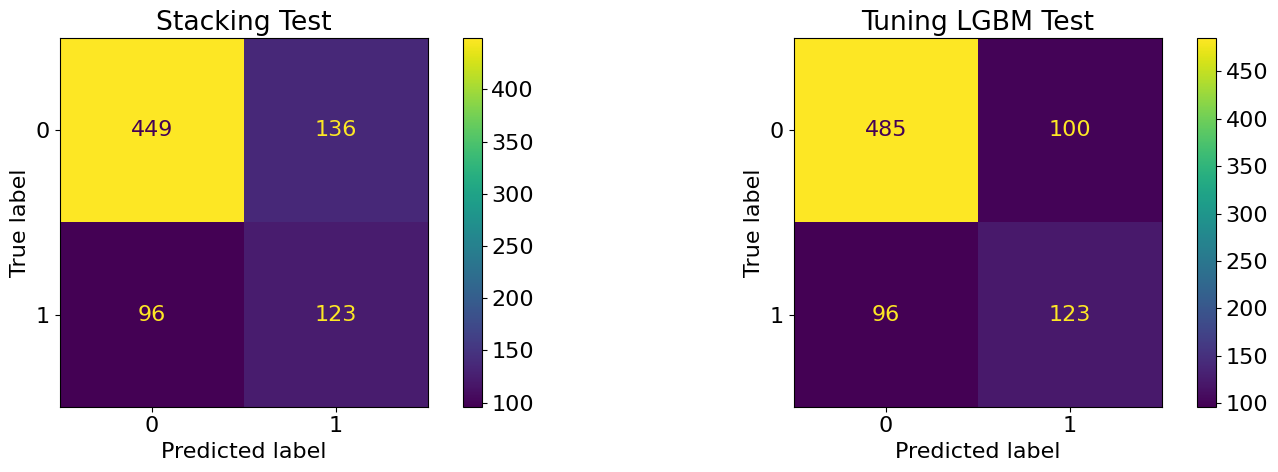

In [33]:
# Посмтрим на ошибки 1 и 2 рода у улгоритма после тюнинга и стекинга
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_confusion_matrix(prediction=y_pred_final, y_true=y_test, X=meta_X_test, ax=axes[0])
plot_confusion_matrix(y_true=y_test, X=X_test, model=lgbm_, ax=axes[1])
axes[0].title.set_text('Stacking Test')
axes[1].title.set_text('Tuning LGBM Test')
plt.tight_layout()  

Кроме незначительного ухудшения метрик, у стекинга больше ошибок для класса 0 - он хуже определяет тех, кто будет безработным. Так же стекинг незначительно увеличил ошибки первого рода (ложные, что человек найдет работу).
Для другого исследования тюнинг или бейзлайн бы лучше подошёл, где в приоритете больше точность и простота алгоритма, например, бизнес-задачи.<br>
<br> <b> <font size=3> Таким образом, лучшей моделью для данной задачи бинарной классификации является Stacking Classifier. 